## Imports and paths

In [1]:
from fastai.vision import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#no need to import pathlib as accessed via fastai
path = Path('data')
path.ls()

[PosixPath('data/wallmasks'),
 PosixPath('data/images'),
 PosixPath('data/walllabels')]

In [4]:
mask_path = path / 'wallmasks'
mask_path.ls()[0:2]

[PosixPath('data/wallmasks/P060_000_000.png'),
 PosixPath('data/wallmasks/P113_000_000.png')]

In [5]:
image_path = path / 'images'
image_path.ls()[0:2]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png')]

In [6]:
label_path = path / 'walllabels'
label_path.ls()[0:2]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png')]

## Data

In [7]:
#get a list of the image filenames
image_fnames_as_list = get_image_files(image_path)
image_fnames_as_list[0:3]


[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png')]

In [8]:
#do the same for label names
label_names_as_list = get_image_files(label_path)
label_names_as_list[0:3]


[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png')]

In [9]:
#do the same for mask names
mask_names_as_list = get_image_files(mask_path)
mask_names_as_list[0:3]

[PosixPath('data/wallmasks/P060_000_000.png'),
 PosixPath('data/wallmasks/P113_000_000.png'),
 PosixPath('data/wallmasks/P002_000_000.png')]

In [10]:
#let us see how many records we have
len(image_fnames_as_list)

122

In [11]:
#check all are equal in length
len(image_fnames_as_list)==len(label_names_as_list)==len(mask_names_as_list)

True

In [12]:
#look at a sample image of each
img_i = image_fnames_as_list[50]
img_l = label_names_as_list[50]
img_m = mask_names_as_list[50]

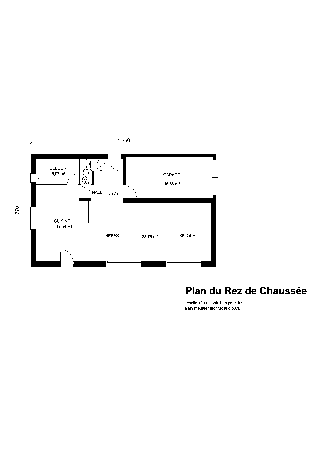

In [13]:
#let us see what is in the files
#not sure what to expect from the label image
open_image(img_i).show(figsize=(8,8))

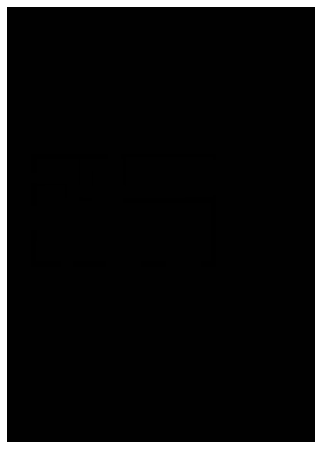

In [14]:
open_image(img_l).show(figsize=(8,8))

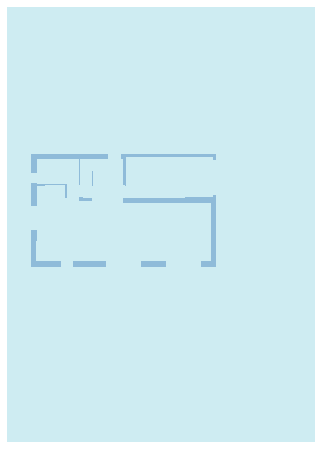

In [15]:
open_mask(img_m).show(figsize=(8,8))

The image shows a house plan in French and the mask<br>
is the wall pixels that have been created by the authors. 

It seems the labels are included for some other purpose than<br>
the image segmentation purpose. We will not use it again.

In [16]:
#The mask is not a standard image file.
#Let us look at the mask shape and contents
mask_file = open_mask(img_m)

print(mask_file.shape)
print(mask_file.data.float().mean())
mask_file.data

torch.Size([1, 3508, 2479])
tensor(249.6844)


tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]])

It is a rank 3 tensor with mostly white pixels.

Fastai is going to need a way to map from the image to<br>
to the mask, or put more plainly, from x to y.

In [17]:
x_to_y_func = lambda x: mask_path / f'{x.stem}{x.suffix}'

In [18]:
#it should return the full mask path
test = x_to_y_func(img_i)
test

PosixPath('data/wallmasks/P056_000_000.png')

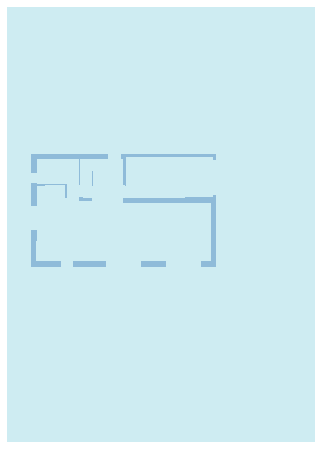

In [19]:
#double check it works to open a mask
open_mask(test).show(figsize=(8,8))

## Create Dataset

In [24]:
#let us use fastai to create a train and validation set
#we can then pass to its datablock api.

seg_list = (
           SegmentationItemList
           .from_folder(image_path)
           .split_by_rand_pct(valid_pct=0.2, seed=22)
           .label_from_func(x_to_y_func, classes=['wall', 'unwalled'])
          )

print(type(seg_list))
seg_list

<class 'fastai.data_block.LabelLists'>


LabelLists;

Train: LabelList (98 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 7383, 5671),Image (3, 7383, 5671),Image (3, 3508, 2480),Image (3, 7383, 5671)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 7383, 5671),ImageSegment (1, 7383, 5671),ImageSegment (1, 3508, 2480),ImageSegment (1, 7383, 5671)
Path: data/images;

Valid: LabelList (24 items)
x: SegmentationItemList
Image (3, 3508, 2480),Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 1486, 1479),Image (3, 2480, 3508)
y: SegmentationLabelList
ImageSegment (1, 3508, 2480),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 1486, 1479),ImageSegment (1, 2480, 3508)
Path: data/images;

Test: None

In [40]:
#pass it to the datablock api

data_block = (seg_list
            .transform
                (
                get_transforms(),
                size=np.array(open_mask(test).shape[1:]),
                tfm_y=True
                )
            .databunch(bs=8)
            .normalize(imagenet_stats))

print(type(data_block))

<class 'fastai.vision.data.ImageDataBunch'>


In [41]:
data_block

ImageDataBunch;

Train: LabelList (98 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479)
Path: data/images;

Valid: LabelList (24 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2479)
Path: data/images;

Test: None

In [45]:
learn = unet_learner(data_block, 
                     models.resnet34, 
                     metrics=accuracy,
                     wd=1e-2).to_fp16()

type(learn)

fastai.basic_train.Learner

In [46]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 266.00 MiB (GPU 0; 15.90 GiB total capacity; 14.81 GiB already allocated; 247.88 MiB free; 181.67 MiB cached)